In [1]:
from __future__ import print_function, division
import torch
import torchvision
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision.models.resnet import ResNet, BasicBlock
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn.metrics as metrics

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class BanknoteDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.labels.iloc[idx, -1])
        image = io.imread(img_name)
        image = cv2.resize(image, (256,256), interpolation=cv2.INTER_LINEAR)
        label = self.labels.iloc[idx, :-1]
        label = np.array(label)
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)
            
        return sample
    
class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image.astype(np.int)),
                'label': torch.from_numpy(label.astype(np.int))}

In [4]:
my_batch_size = 50
root_dir = "ThaiCurrencies"
train_data = BanknoteDataset("one_hot_labels.csv", root_dir, transform = transforms.Compose([ToTensor()]))
train_data_loader = DataLoader(train_data, batch_size=my_batch_size, shuffle=True, num_workers=0)

#小数据集就用 batch 4吧
test_data = BanknoteDataset('test_data.csv', root_dir, transform = transforms.Compose([ToTensor()]))
test_data_loader = DataLoader(test_data, batch_size=4, shuffle=True, num_workers=0)

val_data = BanknoteDataset('val_data.csv', root_dir, transform = transforms.Compose([ToTensor()]))
val_loader = DataLoader(test_data, batch_size=4, shuffle=True, num_workers=0)

data_pd = pd.DataFrame()

In [5]:
#prep - 这几行不要重复运行！！！
import torch.optim as optim
criterion = nn.CrossEntropyLoss().to(device)
train_loss = []
val_loss = []
acc_t = []
acc_v = []

In [6]:
#train训练，validation评测，往accuracy和loss后面append数据
def train_eval(num_epoch,learning_rate,start,max_accu = 0):
    #start 就是为了记录在这个lr之前train了多少epoch
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    temp = 0
    net.to(device)
    for epoch in range(num_epoch):
        net.train()
        class_correct=0
        class_total =0
        for i, data in enumerate(train_data_loader):
            inputs = data['image'].float().to(device)
            labels = data['label'].float().to(device)
            
            #Get Perturbation/Gradient
            net.eval()
            inputs.requires_grad = True
            outputs = net(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            optimizer.zero_grad()
            loss.backward()
            data_grad = inputs.grad.data
            inputs = fgsm_attack(inputs, 2, data_grad)
            
            #Adversarial Training
            net.train()
            outputs = net(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            temp+=loss.item()
            
            
            #accuracy below
            c = (torch.max(outputs, 1)[1] == torch.max(labels, 1)[1]).squeeze()
            for i in range(len(c)):
                if(c[i]):
                    class_correct += 1
                class_total += 1
        acc_t.append( class_correct/class_total )
        #loss below
        train_loss.append(temp/len(train_data_loader))
        #reset temp
        temp = 0

        
        net.eval()
        class_correct=0 
        class_total =0
        for i, data in enumerate(val_loader):
            inputs = data['image'].float().to(device)
            labels = data['label'].float().to(device)
            outputs = net(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            temp+=loss.item()
            
            
            #accuracy below
            c = (torch.max(outputs, 1)[1] == torch.max(labels, 1)[1]).squeeze()
            for i in range(len(c)):
                if(c[i]):
                    class_correct += 1
                class_total += 1
        accu = class_correct/class_total
        acc_v.append(accu)
        #loss below
        ave_loss = temp/len(val_loader)
        val_loss.append(ave_loss)
        print('epoch',epoch + start,end = ' ')
        print("Validation loss %f" %  ave_loss)
        #reset temp
        temp = 0
        
        #每十个epoch存一下model
        k = epoch+start
        if(k%10==0):
            file_name = 'MobileNet_adv/epoch'+str(k)+'lr'+str(learning_rate)+'.pth'
            torch.save(net.state_dict(), file_name)
        max_accu = max_accu
        if(accu>max_accu and accu>0.94):
            max_accu = accu
            file_name = 'MobileNet_adv/max_'+str(accu)+ '_lr'+str(learning_rate)+'epoch'+str(k)+'.pth'
            torch.save(net.state_dict(), file_name)
    data_pd = pd.DataFrame({'train_loss':train_loss,
                            'val_loss': val_loss,
                            'acc_t':acc_t,
                            'acc_v':acc_v})
    return max_accu,data_pd
    

In [7]:

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad, targeted = None):
    sign_data_grad = data_grad.sign()
    if(targeted):
        perturbed_image = image - epsilon*sign_data_grad
    else:
        perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 255)
    return perturbed_image

def plot_confusion_matrix(y_true,y_pred,eps,acc):
    confusion_matrix = metrics.confusion_matrix(y_true,y_pred)
    acc_confusion_matrix = confusion_matrix/20
    plt.imshow(acc_confusion_matrix,interpolation = 'nearest',cmap = 'Blues')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(ticks = [0,1,2,3,4],labels = [100,1000,20,50,500])
    plt.yticks(ticks = [0,1,2,3,4],labels = [100,1000,20,50,500])
    plt.colorbar()
    plt.title('Epsilon:{}, Accuracy:{}%'.format(eps,acc*100))
    for i in range(len(confusion_matrix)):
        for j in range(len(confusion_matrix)):
            count = confusion_matrix[j][i]
            plt.text(i,j,'{:1}\n{:1}%'.format(count,count/0.2),horizontalalignment='center',
                     verticalalignment='center',color = 'white' if count>11 else 'black')
    #plt.savefig('eps%dacc%d'%(eps,acc*100),dpi = 300)

In [33]:
PATH= 'MobileNet/epoch10lr0.001.pth'
net = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
net.load_state_dict(torch.load(PATH))

Using cache found in C:\Users\hands/.cache\torch\hub\pytorch_vision_v0.6.0


<All keys matched successfully>

In [34]:
#这就是在跑，疯狂地跑
max_accu,data_pd=train_eval(num_epoch=21,learning_rate=0.001,start = 0)
print('Finished Training')

epoch 0 Validation loss 0.117861
epoch 1 Validation loss 0.116393
epoch 2 Validation loss 0.088741
epoch 3 Validation loss 0.103968
epoch 4 Validation loss 0.105024
epoch 5 Validation loss 0.060519
epoch 6 Validation loss 0.074820
epoch 7 Validation loss 0.093452
epoch 8 Validation loss 0.047830
epoch 9 Validation loss 0.078173
epoch 10 Validation loss 0.057523
epoch 11 Validation loss 0.066068
epoch 12 Validation loss 0.138286
epoch 13 Validation loss 0.043769
epoch 14 Validation loss 0.098547
epoch 15 Validation loss 0.069518
epoch 16 Validation loss 0.079437
epoch 17 Validation loss 0.069350
epoch 18 Validation loss 0.057855
epoch 19 Validation loss 0.113108
epoch 20 Validation loss 0.049437
Finished Training


In [42]:
#Store Things
data_pd.to_csv('MobileNet_adv/train_val_loss&acc.csv')
file_name = 'MobileNet_adv/final_eps3.pth'
torch.save(net.state_dict(), file_name)

In [8]:
df = pd.read_csv('MobileNet_adv/train_val_loss&acc.csv')

In [10]:
train_loss = df['train_loss']
val_loss = df['val_loss']
acc_t = df['acc_t']
acc_v = df['acc_v']

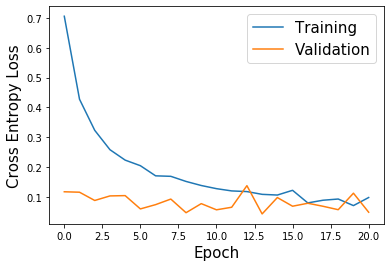

In [35]:
#这不得让人开心啊
plt.plot(range(len(train_loss)),train_loss)
plt.plot(range(len(val_loss)),val_loss)
plt.xlabel('Epoch',size = 15)
plt.ylabel('Cross Entropy Loss',size = 15)
labels = ['Training','Validation']
plt.legend(labels, prop={'size': 15})
plt.savefig("loss_epoch4",dpi = 300)

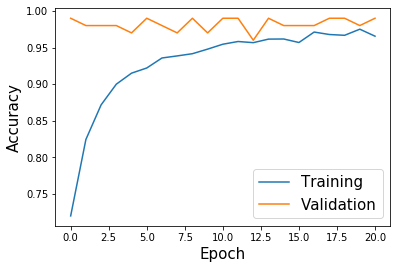

In [36]:
#这不得更开心啊
plt.plot(range(len(acc_t)),acc_t)
plt.plot(range(len(acc_v)),acc_v)
plt.xlabel('Epoch',size = 15)
plt.ylabel('Accuracy',size = 15)
labels = ['Training','Validation']
plt.legend(labels, prop={'size': 15})
plt.savefig("accuracy4",dpi = 300)

In [37]:
#seperate class accuracy - validation set
net.eval()
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
net.to(device)
with torch.no_grad():
    for i, data in enumerate(test_data_loader):
        images = data['image'].float().to(device)
        label = data['label'].float().to(device)
        outputs = net(images)
        
        #print(torch.max(outputs, 1)[1])
        #print(torch.max(label, 1)[1])
        
        cat_outputs = torch.max(outputs, 1)[1]
        cat_label = torch.max(label, 1)[1]
        c = (cat_outputs == cat_label).squeeze()
        for i in range(len(c)):
            lab = cat_label[i]
            if(c[i]):
                class_correct[lab] += 1
            class_total[lab] += 1
print(class_correct)
print(class_total)
for i in range(5):
    print('Testing Accuracy class %2d: %2d %%' % (i,100 * class_correct[i] / class_total[i]))
    #130 epoch

[20.0, 20.0, 20.0, 19.0, 20.0]
[20.0, 20.0, 20.0, 20.0, 20.0]
Testing Accuracy class  0: 100 %
Testing Accuracy class  1: 100 %
Testing Accuracy class  2: 100 %
Testing Accuracy class  3: 95 %
Testing Accuracy class  4: 100 %


In [58]:
wrong_pred_image = []
net.eval()
class_correct = 0
class_total = 0
net.to(device)
with torch.no_grad():
    for i, data in enumerate(train_data_loader):
        images = data['image'].float().to(device)
        label = data['label'].float().to(device)
        outputs = net(images)
        
        #print(torch.max(outputs, 1)[1])
        #print(torch.max(label, 1)[1])
        
        cat_outputs = torch.max(outputs, 1)[1]
        cat_label = torch.max(label, 1)[1]
        c = (cat_outputs == cat_label).squeeze()
        for i in range(len(c)):
            if(c[i]):
                class_correct += 1
            else:
                wrong_pred_image.append(images[i])
            class_total += 1
print(class_correct)
print(class_total)
print('Training Accuracy  %2d %%' % (100 * class_correct / class_total))

24807
24809
Training Accuracy  99 %


In [8]:
def fgsm_test(epsilons,target_class = None):
    y_true = []
    y_pred = []
    acc = []
    acc_by_class = list([] for i in range(5))
    for epsilon in epsilons:
        correct = 0
        total = 0
        acc_cnt_class = list(0 for i in range(5))
        for i_batch, sample_batched in enumerate(test_data_loader):
            data, label_batch = sample_batched['image'].float().to(device), sample_batched['label'].float().to(device)
            batch_size = len(data)
            data.requires_grad = True
            outputs = net(data)
            if(target_class):
                target_label = torch.tensor(list(target_class for i in range(4))).to(device)
                loss = criterion(outputs,target_label)
            else:
                loss = criterion(outputs,torch.max(label_batch, 1)[1])
            net.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            p_data = fgsm_attack(data, epsilon, data_grad, target_class)
            p_outputs = net(p_data)

            c = (torch.max(p_outputs,1)[1] == torch.max(label_batch,1)[1])
            for i in range(len(c)):
                y_pred.append(torch.max(p_outputs,1)[1][i].cpu().numpy())
                y_true.append(torch.max(label_batch,1)[1][i].cpu().numpy())
                if(c[i]):
                    correct+=1
                    acc_cnt_class[torch.max(label_batch,1)[1][i]]+=1
                total+=1
        acc.append(correct/total)
        for i in range(5):
            acc_by_class[i].append(acc_cnt_class[i]/20)
        if(epsilon%1==0):
            print('epsilon %.2f : %.2f' %( epsilon , correct/total))
    return epsilons,acc,acc_by_class,y_true,y_pred
            #grid = utils.make_grid(p_data.int())
            #plt.figure(figsize = (10,10))
            #plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))

epsilon 0.00 : 0.99


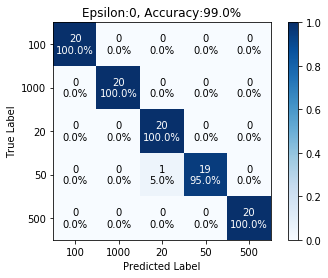

epsilon 1.00 : 0.92


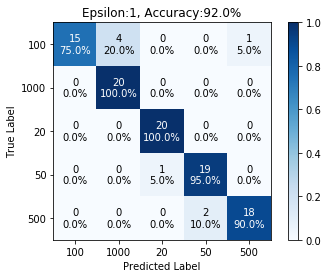

epsilon 2.00 : 0.67


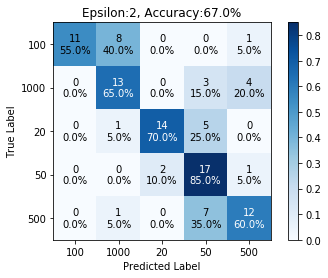

epsilon 3.00 : 0.53


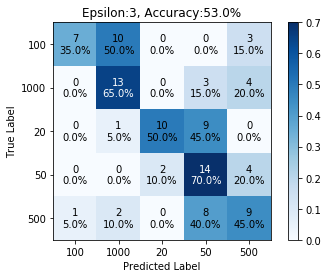

epsilon 4.00 : 0.36


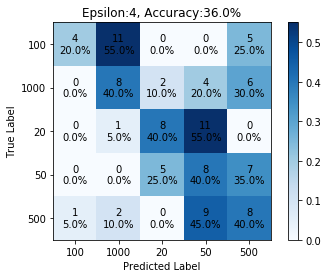

In [33]:
classes = [100,1000,20,50,500]
for i in range(5):
    _,acc,_,ytrue,ypred = fgsm_test([i])
    plot_confusion_matrix(ytrue,ypred,i,acc[0])
    plt.savefig('eps%dacc%dclass%d'%(2,acc[0]*100,classes[i]),dpi = 300)
    plt.show()

epsilon 2.00 : 0.67


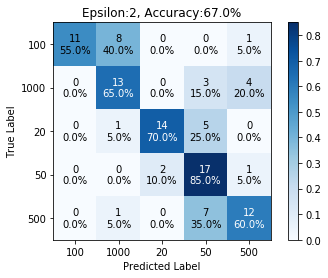

epsilon 2.00 : 0.82


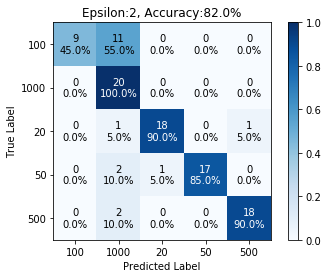

epsilon 2.00 : 0.87


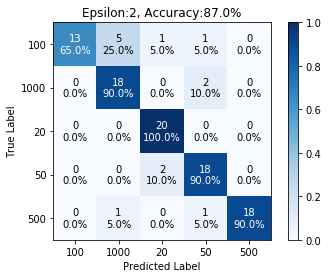

epsilon 2.00 : 0.76


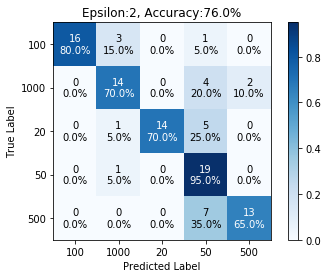

epsilon 2.00 : 0.84


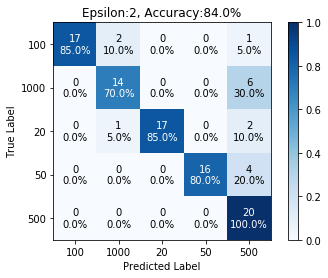

In [34]:
classes = [100,1000,20,50,500]
for i in range(5):
    _,acc,_,ytrue,ypred = fgsm_test([2],i)
    plot_confusion_matrix(ytrue,ypred,2,acc[0])
    plt.savefig('eps%dacc%dclass%d'%(2,acc[0]*100,classes[i]),dpi = 300)
    plt.show()

In [11]:
print('\u03b5d')

εd


Using cache found in C:\Users\hands/.cache\torch\hub\pytorch_vision_v0.6.0


epsilon 0.00 : 0.99
epsilon 3.00 : 0.78
epsilon 0.00 : 0.99
epsilon 3.00 : 0.53
epsilon 0.00 : 1.00
epsilon 3.00 : 0.26


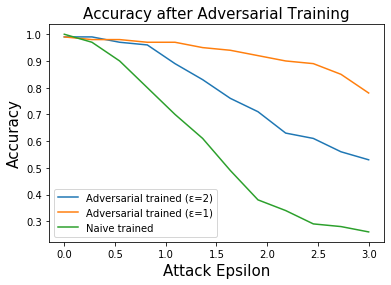

In [12]:
epsilons= np.linspace(0,3,12)
net = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True).to(device)
net.load_state_dict(torch.load('MobileNet_adv/final_eps2.pth'))
net.eval()
x_eps2,y_acc2,_,_,_ = fgsm_test(epsilons)
net.load_state_dict(torch.load('MobileNet_adv/final.pth'))
net.eval()
x_eps1,y_acc1,_,_,_ = fgsm_test(epsilons)
net.load_state_dict(torch.load('MobileNet/final57.pth'))
net.eval()
x_eps0,y_acc0,_,_,_ = fgsm_test(epsilons)
plt.xlabel('Attack Epsilon',size = 15)
plt.ylabel('Accuracy',size = 15)
plt.plot(x_eps1,y_acc1)
plt.plot(x_eps2,y_acc2)
plt.plot(x_eps0,y_acc0)
plt.legend(labels = ['Adversarial trained (\u03b5=2)','Adversarial trained (\u03b5=1)','Naive trained'])
plt.title('Accuracy after Adversarial Training',size = 15)
plt.savefig('MobileNet_adv/eps2acc_comparison0-2',dpi=300)

epsilon 0.00 : 1.00
epsilon 5.00 : 0.24


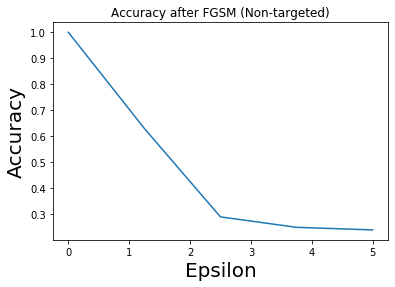

In [63]:
net.load_state_dict(torch.load('MobileNet/final57.pth'))
epsilons= np.linspace(0,5,5)
x_eps,y_acc,acc_bc,_,_ = fgsm_test(epsilons)
plt.xlabel('Epsilon',size = 20)
plt.ylabel('Accuracy',size = 20)
plt.plot(x_eps,y_acc)
plt.title('Accuracy after FGSM (Non-targeted)')
plt.savefig('57_acc_epsilon',dpi=300)